# About Q-Learning algorithm
> "Q-learning is a model-free reinforcement learning algorithm. The goal of Q-learning is to learn a policy, which tells an agent what action to take under what circumstances. It does not require a model (hence the connotation "model-free") of the environment, and it can handle problems with stochastic transitions and rewards, without requiring adaptations."
[*wiki*](https://en.wikipedia.org/wiki/Q-learning)

<a class="anchor" id="ToC"></a>
# Table of Contents
1. [Install libraries](#install_libraries)
1. [Import libraries](#import_libraries)
1. [Define useful classes](#define_useful_classes)
1. [Create ConnectX environment](#create_connectx_environment)
1. [Configure hyper-parameters](#configure_hyper_parameters)
1. [Train the agent](#train_the_agent)
1. [Create an agent](#create_an_agent)
1. [Evaluate the agent](#evaluate_the_agent)

<a class="anchor" id="install_libraries"></a>
# Install libraries
[Back to Table of Contents](#ToC)

In [1]:
!pip install 'kaggle-environments==0.1.6' > /dev/null 2>&1

The system cannot find the path specified.


<a class="anchor" id="import_libraries"></a>
# Import libraries
[Back to Table of Contents](#ToC)

In [1]:
import numpy as np
import gym
import random
import matplotlib.pyplot as plt
from random import choice
from tqdm import tqdm
from kaggle_environments import evaluate, make
import threading
from multiprocessing import Process
import multiprocessing as mp
from os.path import exists
import json

import time
import datetime as dt

Loading environment lux_ai_2022 failed: No module named 'vec_noise'


<a class="anchor" id="define_useful_classes"></a>
# Define useful classes
NOTE: It's not easy to generate a Q-Table with all possible states; and even if I can do so, the huge number of states will cost much of memory. So, I use the approach that dynamically adding newly discovered states into an object of QTable class created below.

[Back to Table of Contents](#ToC)

In [89]:
class ConnectX(gym.Env):
    def __init__(self, switch_prob=0.5):
        self.env = make('connectx', debug=True)
        self.pair = [None, 'negamax']
        self.trainer = self.env.train(self.pair)
        self.switch_prob = switch_prob
        
        # Define required gym fields (examples):
        config = self.env.configuration
        self.action_space = gym.spaces.Discrete(config.columns)
        self.observation_space = gym.spaces.Discrete(config.columns * config.rows)

    def switch_trainer(self):
        self.pair = self.pair[::-1]
        self.trainer = self.env.train(self.pair)

    def step(self, action):
        return self.trainer.step(action)
    
    def reset(self):
        if random.uniform(0, 1) < self.switch_prob:
            self.switch_trainer()
        return self.trainer.reset()
    
    def render(self, **kwargs):
        return self.env.render(**kwargs)

    
class QTable:
    def __init__(self, action_space):
        self.file = 'qtable.json'
        self.load_table()
        self.action_space = action_space
        
    def add_item(self, state_key):
        self.table[state_key] = list(np.zeros(self.action_space.n))
        
    def __call__(self, state):
        board = state['board'][:] # Get a copy
        board.append(state.mark)
        state_key = np.array(board).astype(str)
        state_key = hex(int(''.join(state_key), 3))[2:]
        if state_key not in self.table.keys():
            self.add_item(state_key)
        
        return self.table[state_key]
    
    def load_table(self, ):
        if exists(self.file):
            f = open(self.file)
            self.table = json.loads(f.read())
            f.close()
        else:
            self.table = dict()

    def save_qtable(self,):
        f = open(self.file,"w")
        document = json.dumps(self.table)
        f.write(document)
        f.close()   

<a class="anchor" id="create_connectx_environment"></a>
# Create ConnectX environment
[Back to Table of Contents](#ToC)

In [90]:
env = ConnectX()

In [91]:
env.__dict__

{'env': <kaggle_environments.core.Environment at 0x175beab7220>,
 'pair': [None, 'negamax'],
 'trainer': {'step': <function kaggle_environments.core.Environment.train.<locals>.step(action)>,
  'reset': <function kaggle_environments.core.Environment.train.<locals>.reset()>},
 'switch_prob': 0.5,
 'action_space': Discrete(7),
 'observation_space': Discrete(42)}

In [92]:
env.env.debug=False

In [93]:
env.env.debug

False

<a class="anchor" id="configure_hyper_parameters"></a>
# Configure hyper-parameters
[Back to Table of Contents](#ToC)

In [94]:
alpha = 0.1
gamma = 0.6
epsilon = 0.99
min_epsilon = 0.3

episodes = 100000

alpha_decay_step = 10000
alpha_decay_rate = 0.99
epsilon_decay_rate = 0.99999

<a class="anchor" id="train_the_agent"></a>
# Train the agent
[Back to Table of Contents](#ToC)

In [95]:
q_table = QTable(env.action_space)

In [96]:
len(q_table.table)

214922

In [97]:
all_epochs = []
all_total_rewards = []
all_avg_rewards = [] # Last 100 steps
all_qtable_rows = []
all_epsilons = []
def trainer(alpha, gamma, epsilon, min_epsilon, episodes, alpha_decay_step, alpha_decay_rate, epsilon_decay_rate):
    env = ConnectX()
    for i in tqdm(range(episodes)):
        if i % 100 == 0:
            q_table.save_qtable()
        state = env.reset()

        epsilon = max(min_epsilon, epsilon * epsilon_decay_rate)
        epochs, total_rewards = 0, 0
        done = False

        while not done:
            if random.uniform(0, 1) < epsilon:
                action = choice([c for c in range(env.action_space.n) if state['board'][c] == 0])
            else:
                row = q_table(state)[:]
                selected_items = []
                for j in range(env.action_space.n):
                    if state['board'][j] == 0:
                        selected_items.append(row[j])
                    else:
                        selected_items.append(-1e7)
                action = int(np.argmax(selected_items))

            next_state, reward, done, info = env.step(action)

            # Apply new rules
            if done:
                if reward == 1: # Won
                    reward = 20
                elif reward == 0: # Lost
                    reward = -20
                else: # Draw
                    reward = 10
            else:
                reward = -0.05 # Try to prevent the agent from taking a long move

            old_value = q_table(state)[action]
            next_max = np.max(q_table(next_state))

            # Update Q-value
            new_value = (1 - alpha) * old_value + alpha * (reward + gamma * next_max)
            q_table(state)[action] = new_value

            state = next_state
            epochs += 1
            total_rewards += reward


        all_epochs.append(epochs)
        all_total_rewards.append(total_rewards)
        avg_rewards = np.mean(all_total_rewards[max(0, i-100):(i+1)])
        all_avg_rewards.append(avg_rewards)
        all_qtable_rows.append(len(q_table.table))
        all_epsilons.append(epsilon)

        if (i+1) % alpha_decay_step == 0:
            alpha *= alpha_decay_rate

In [98]:
trainer(alpha, gamma, epsilon, min_epsilon, episodes, alpha_decay_step, alpha_decay_rate, epsilon_decay_rate)

  0%|▏                                                                         | 278/100000 [02:27<14:43:21,  1.88it/s]


KeyboardInterrupt: 

In [15]:
len(q_table.table)

990

[9.6,
 9.35,
 9.3,
 9.9,
 9.65,
 9.55,
 9.75,
 9.15,
 9.7,
 9.85,
 9.75,
 9.7,
 9.9,
 9.8,
 9.55,
 9.45,
 9.85,
 9.45,
 9.55,
 9.15,
 9.85,
 9.45,
 9.6,
 9.75,
 9.75,
 9.85,
 9.85,
 9.85,
 9.7,
 9.85,
 9.75,
 9.55,
 9.8,
 9.5,
 -21.0,
 9.9,
 19.05,
 9.7,
 9.1,
 9.65,
 9.65,
 9.8,
 9.85,
 9.85,
 9.65,
 9.9,
 19.4,
 9.75,
 9.7,
 9.6,
 9.55,
 9.5,
 9.6,
 9.5,
 9.9,
 9.7,
 9.65,
 9.9,
 9.55,
 9.85,
 9.7,
 9.9,
 9.85,
 9.4,
 9.35,
 9.7,
 9.8,
 9.6,
 9.9,
 9.6,
 9.55,
 9.65,
 9.35,
 9.5,
 9.8,
 9.8,
 9.75,
 9.6,
 9.7,
 9.45,
 9.9,
 9.4,
 9.9,
 9.75,
 9.25,
 9.5,
 9.65,
 9.65,
 9.65,
 9.4,
 9.8,
 9.8,
 9.85,
 9.85,
 9.8,
 9.75,
 9.4,
 9.25,
 9.5,
 9.75,
 9.55,
 9.65,
 9.9,
 9.9,
 9.65,
 9.85,
 9.65,
 9.65,
 9.7,
 9.9,
 9.85,
 9.7,
 9.45,
 9.5,
 9.5,
 9.25,
 9.85,
 9.8,
 9.85,
 9.85,
 9.65,
 9.75,
 9.75,
 9.6,
 9.9,
 9.55,
 9.85,
 9.8,
 9.9,
 9.85,
 9.55,
 9.85,
 9.9,
 9.6,
 9.85,
 9.75,
 9.55,
 9.55,
 9.85,
 9.45,
 9.85,
 9.75,
 9.6,
 9.75,
 9.6,
 9.3,
 9.7,
 9.75,
 9.85,
 9.8,
 9.4,
 9.6,
 9

In [23]:
# for k in q_table.table.keys():
#     print('State:', k)
#     print('Action-Value:', list(q_table.table[k]), '\n')

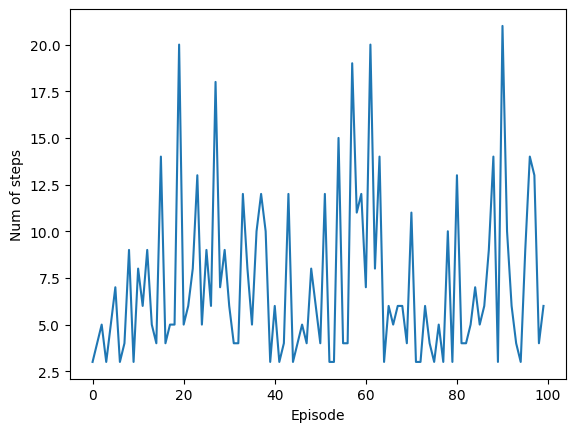

In [43]:
plt.plot(all_epochs[50000:50100])
plt.xlabel('Episode')
plt.ylabel('Num of steps')
plt.show()

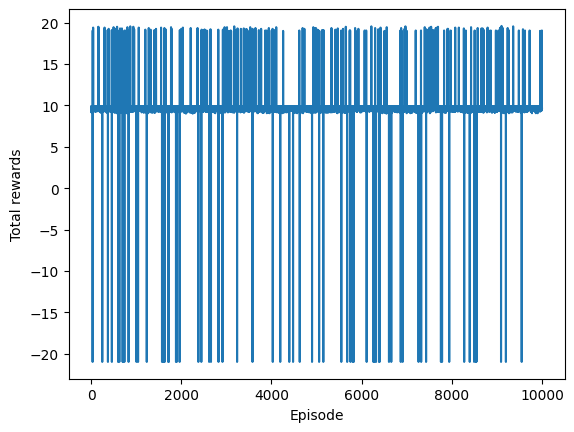

In [50]:
plt.plot(all_total_rewards[0:10000])
plt.xlabel('Episode')
plt.ylabel('Total rewards')
plt.show()

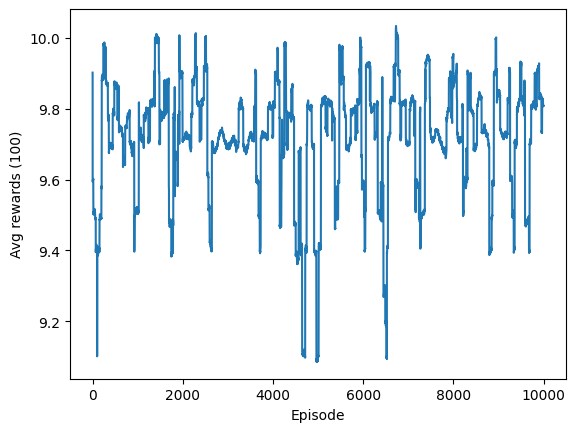

In [52]:
plt.plot(all_avg_rewards[40000:50000])
plt.xlabel('Episode')
plt.ylabel('Avg rewards (100)')
plt.show()

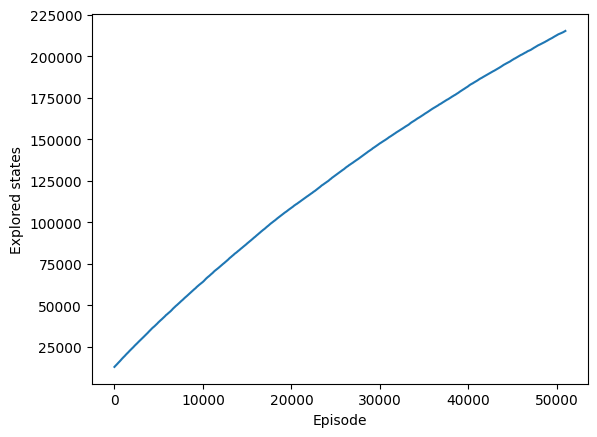

In [36]:
plt.plot(all_qtable_rows)
plt.xlabel('Episode')
plt.ylabel('Explored states')
plt.show()

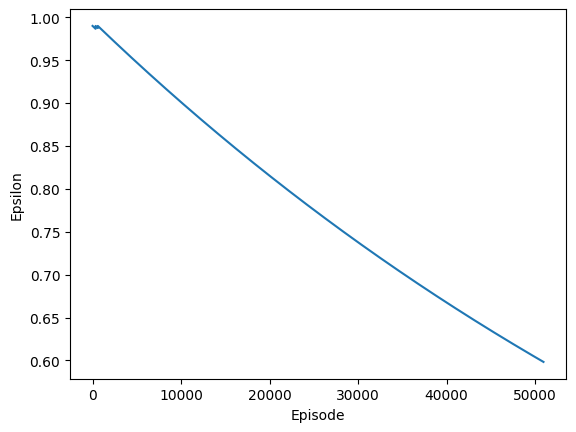

In [37]:
plt.plot(all_epsilons)
plt.xlabel('Episode')
plt.ylabel('Epsilon')
plt.show()

<a class="anchor" id="create_an_agent"></a>
# Create an Agent
[Back to Table of Contents](#ToC)

In [24]:
tmp_dict_q_table = q_table.table.copy()
dict_q_table = dict()

for k in tmp_dict_q_table:
    if np.count_nonzero(tmp_dict_q_table[k]) > 0:
        dict_q_table[k] = int(np.argmax(tmp_dict_q_table[k]))

In [25]:
my_agent = '''def my_agent(observation, configuration):
    from random import choice

    q_table = ''' \
    + str(dict_q_table).replace(' ', '') \
    + '''

    board = observation.board[:]
    board.append(observation.mark)
    state_key = list(map(str, board))
    state_key = hex(int(''.join(state_key), 3))[2:]

    if state_key not in q_table.keys():
        return choice([c for c in range(configuration.columns) if observation.board[c] == 0])

    action = q_table[state_key]

    if observation.board[action] != 0:
        return choice([c for c in range(configuration.columns) if observation.board[c] == 0])

    return action
    '''

In [26]:
with open('submission.py', 'w') as f:
    f.write(my_agent)

<a class="anchor" id="evaluate_the_agent"></a>
# Evaluate the agent
[Back to Table of Contents](#ToC)

In [28]:
from submission import my_agent

In [29]:
def mean_reward(rewards):
    return sum(r[0] for r in rewards) / sum(r[0] + r[1] for r in rewards)

# Run multiple episodes to estimate agent's performance.
print("My Agent vs Random Agent:", mean_reward(evaluate("connectx", [my_agent, "random"], num_episodes=10)))
print("My Agent vs Negamax Agent:", mean_reward(evaluate("connectx", [my_agent, "negamax"], num_episodes=10)))

ZeroDivisionError: division by zero